In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Encuesta de remuneración salarial de sysarmy - 2018.1 - Argentina.csv', skiprows=3)

In [3]:
df_filtered = df[df['Salario mensual (en tu moneda local)'] <= 200000]
df_filtered = df_filtered[df_filtered['Salario mensual (en tu moneda local)'] > 10000]
df_filtered = df_filtered[df_filtered['¿Bruto o neto?'] == 'Bruto']
df_filtered = df_filtered[df_filtered['Tipo de contrato'] == 'Full-Time']

In [4]:
df_filtered['age'] = df_filtered['Tengo'].apply(lambda x: {
    '27 - 30': 28.5,
    '31 - 33': 32,
    '34 - 36': 35,
    '37 - 40': 38.5,
    '24 - 26': 25,
    '21 - 23': 22,
    '41 - 45': 43,
    '46 - 49': 48.5,
    '50+': 57,
    '18 - 20': 19,
    'Menos de 18 años': 17,
}[x])
df_filtered['sex'] = df_filtered['Me identifico'].apply(lambda x: {'Hombre': 0, 'Mujer': 1, 'Otros': 2}[x])

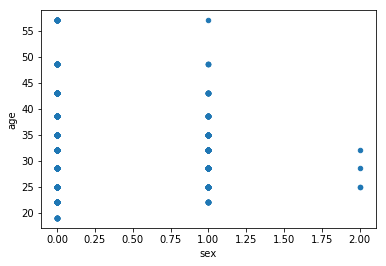

In [5]:
df_filtered.plot(x='sex', y='age', kind='scatter');

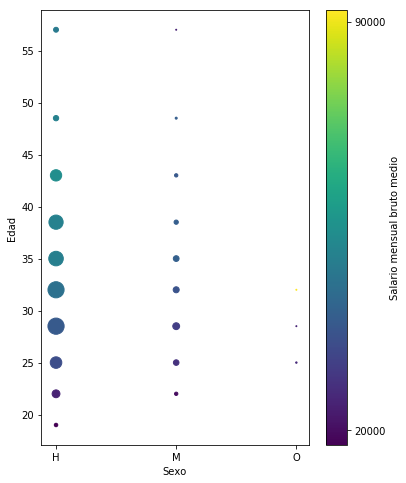

In [6]:
def plot_scatter(df, x, xlabel, y, ylabel, c, clabel, cagg='median', cticks=None, xticks=None, yticks=None):
    xyc = df.groupby((x, y)).agg({'Tengo': ['count'], c: [cagg]}).reset_index()
    plt.figure(figsize=(6, 8))
    sc = plt.scatter(x=xyc[x].tolist(), y=xyc[y].tolist(), s=xyc['Tengo'], c=xyc[c][cagg].tolist())
    cbar = plt.colorbar(sc, ticks=cticks)
    cbar.set_label(clabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks:
        plt.xticks(list(xticks.keys()), list(xticks.values()))
    if yticks:
        plt.yticks(list(yticks.keys()), list(yticks.values()))
    return plt.show()

plot_scatter(df_filtered, 'sex', 'Sexo', 'age', 'Edad', 'Salario mensual (en tu moneda local)', 'Salario mensual bruto medio',
             cticks=[20000, 90000],
             xticks={0: 'H', 1: 'M', 2: 'O'}
            )

In [7]:
df_filtered = df_filtered[df_filtered['sex'] < 2]

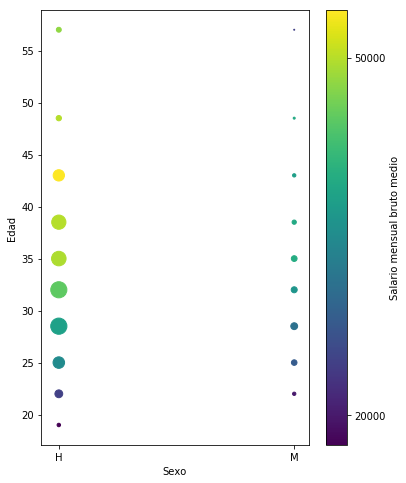

In [8]:
plot_scatter(df_filtered, 'sex', 'Sexo', 'age', 'Edad', 'Salario mensual (en tu moneda local)', 'Salario mensual bruto medio',
             cticks=[20000, 50000],
             xticks={0: 'H', 1: 'M'}
            )

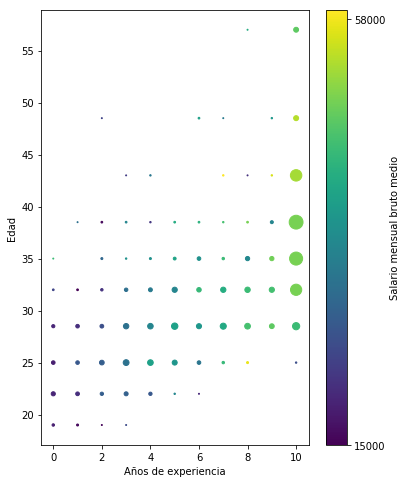

In [9]:
df_filtered['experience'] = df_filtered['Años de experiencia'].apply(lambda x: int({
    'Menos de un año': 0,
    '10+': 10,
}.get(x, x)))
plot_scatter(df_filtered, 'experience', 'Años de experiencia', 'age', 'Edad', 'Salario mensual (en tu moneda local)', 'Salario mensual bruto medio',
             cticks=[15000, 58000],
            )

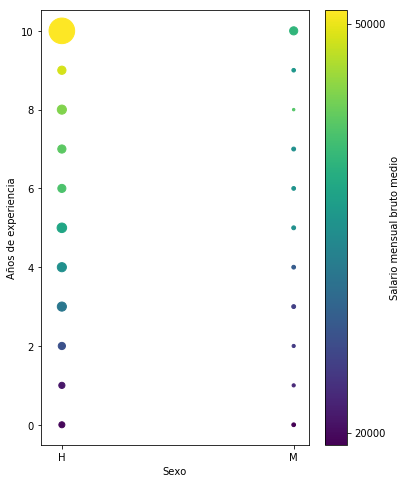

In [11]:
plot_scatter(df_filtered, 'sex', 'Sexo', 'experience', 'Años de experiencia', 'Salario mensual (en tu moneda local)', 'Salario mensual bruto medio',
             cticks=[20000, 50000],
             xticks={0: 'H', 1: 'M'}
            )

In [20]:
df_filtered[['age', 'sex', 'experience']].corr()

,age,sex,experience
age,1.000000,-0.081952,0.640271
sex,-0.081952,1.000000,-0.115981
experience,0.640271,-0.115981,1.000000


In [34]:
from math import log
def is_desistemas(x):
    x = str(x).lower()
    return int('sistemas' in x or 'informática' in x or 'informatica' in x or 'computación' in x or 'computacion' in x or 'programador' in x or 'programación' in x)

def experience_years(y):
    return {
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        '6': 6,
        '7': 7,
        '8': 8,
        '9': 9,
        '10+': 10,
        'Menos de un año': 0,
    }[y]

def transform_row(row):
    d = {}
    all_techs = ','.join((
        str(row['Tecnologías que utilizás']),
        str(row['Tecnologías que utilizás.1']),
        str(row['Tecnologías que utilizás.2']),
        str(row['Tecnologías que utilizás.3']),
        str(row['Tecnologías que utilizás.4']),
    ))
    for key, tech in {
        'linux': ('Linux', ),
        'windows': ('.NET', 'C#', 'Windows',),
        'vmware': ('VMWare',),
        'cloud': ('Azure', 'Amazon Web Services'),
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Python', 'Perl', 'Scala'),
        'mobile': ('Swift', 'Objective-C'),
        'automated_test': ('Selenium', 'Visual Studio Coded UI', 'OpenQA', 'HP LoadRunner', 'Test Complete', 'Watir', 'Postman', 'RSpec', 'JMeter'),
        'sql': ('Oracle', 'MSSQL', 'MySQL', 'MariaDB', 'PostgreSQL', 'SQL'),
        'nosql': ('Redis', 'MongoDB', 'Hadoop', 'Cassandra', 'Google bigQuery'),
    }.items():
        d['is_{}'.format(key)] = int(any(map(lambda t: t in all_techs, tech)))

    d['is_Ciudad Autónoma de Buenos Aires'] = int(row['Argentina'] in ('Ciudad Autónoma de Buenos Aires',))
    d['is_Provincia de Buenos Aires'] = int(row['Argentina'] in ('Provincia de Buenos Aires',))
    d['is_GBA'] = int(row['Argentina'] in ('GBA',))
    d['is_patagonia'] = int(row['Argentina'] in ('Chubut', 'Tierra del Fuego', 'Neuquén', 'Santa Cruz', 'Río Negro'))
    d['is_pampa'] = int(row['Argentina'] in ('Córdoba', 'Santa Fe', 'La Pampa'))
    d['is_cuyo'] = int(row['Argentina'] in ('Mendoza', 'San Luis', 'San Juan'))
    d['is_centro'] = int(row['Argentina'] in ('Chaco', 'Santiago del Estero', 'Formosa'))

    d.update({
        'is_male': int(row['Me identifico'] == 'Hombre'),
        'age': {
            '27 - 30': 28.5,
            '31 - 33': 32,
            '34 - 36': 35,
            '37 - 40': 38.5,
            '24 - 26': 25,
            '21 - 23': 22,
            '41 - 45': 43,
            '46 - 49': 48.5,
            '50+': 57,
            '18 - 20': 19,
            'Menos de 18 años': 17,
        }[row['Tengo']],
        'experience_years': experience_years(row['Años de experiencia']),
        'current_position_years': experience_years(row['Años en el puesto actual']),
        'log_in_charge_of': log(int(row['¿Cuánta?']) + 1, 10),
        'study': {
            'Primario (Incompleto)': 0,
            'Primario (En curso)': 0,
            'Primario (Completado)': 1,
            'Secundario (Incompleto)': 2,
            'Secundario (En curso)': 3,
            'Secundario (Completado)': 4,
            'Terciario (Incompleto)': 5,
            'Terciario (En curso)': 5,
            'Universitario (En curso)': 5,
            'Universitario (Incompleto)': 5,
            'Terciario (Completado)': 6,
            'Universitario (Completado)': 7,
            'Doctorado (En curso)': 7,
            'Posgrado (En curso)': 7,
            'Posgrado (Incompleto)': 7,
            'Doctorado (Incompleto)': 7,
            'Posgrado (Completado)': 8,
            'Doctorado (Completado)': 9,
        }['{} ({})'.format(row['Nivel de estudios alcanzado'], row['Estado'])],
        'is_computer_degree': is_desistemas(row['Carrera']),
        'is_developer': int(row['Trabajo de'] == 'Developer'),
        'is_sysadmin': int(row['Trabajo de'] == 'SysAdmin / DevOps'),
        'is_helpdesk': int(row['Trabajo de'] == 'HelpDesk'),
        'is_networking': int(row['Trabajo de'] == 'Networking'),
        'is_pm': int(row['Trabajo de'] == 'PM'),
        'is_qa': int(row['Trabajo de'] == 'QA / Tester'),
        'is_architect': int(row['Trabajo de'] == 'Architect'),
        'is_designer': int(row['Trabajo de'] == 'Designer'),
        'is_startup': int(row['Cantidad de empleados'] in ('1-10', '11-50')),
        'has_flexible_timing': int('Horarios flexibles' in row['Beneficios extra']),
        'has_wfh': int('WFH' in row['Beneficios extra']),
        'has_laptop': int('Laptop' in row['Beneficios extra']),
        'has_inflation_rise': int('Aumento por inflación' in row['Beneficios extra']),
        'has_capacitation': int('Capacitaciones y/o cursos' in row['Beneficios extra']),
        'has_language_courses': int('Clases de idiomas' in row['Beneficios extra']),
        'has_gym_discount': int('Descuentos en gimnasios' in row['Beneficios extra']),
        'has_snacks': int('snacks' in row['Beneficios extra'].lower()),
        'has_drinks': int('bebidas' in row['Beneficios extra'].lower()),
        'has_candies': int('golosinas' in row['Beneficios extra'].lower()),
        'has_internet': int('Abono de celular y/o Internet' in row['Beneficios extra']),
        'has_food': int('Comidas pagas' in row['Beneficios extra']),
        'has_bonus': int('Bonos por desempeño' in row['Beneficios extra']),
    })
    if 'Salario mensual (en tu moneda local)' in row:
        d['salary'] = int(row['Salario mensual (en tu moneda local)'])
    return d

df_ready = df_filtered.apply(transform_row, axis=1, result_type='expand')

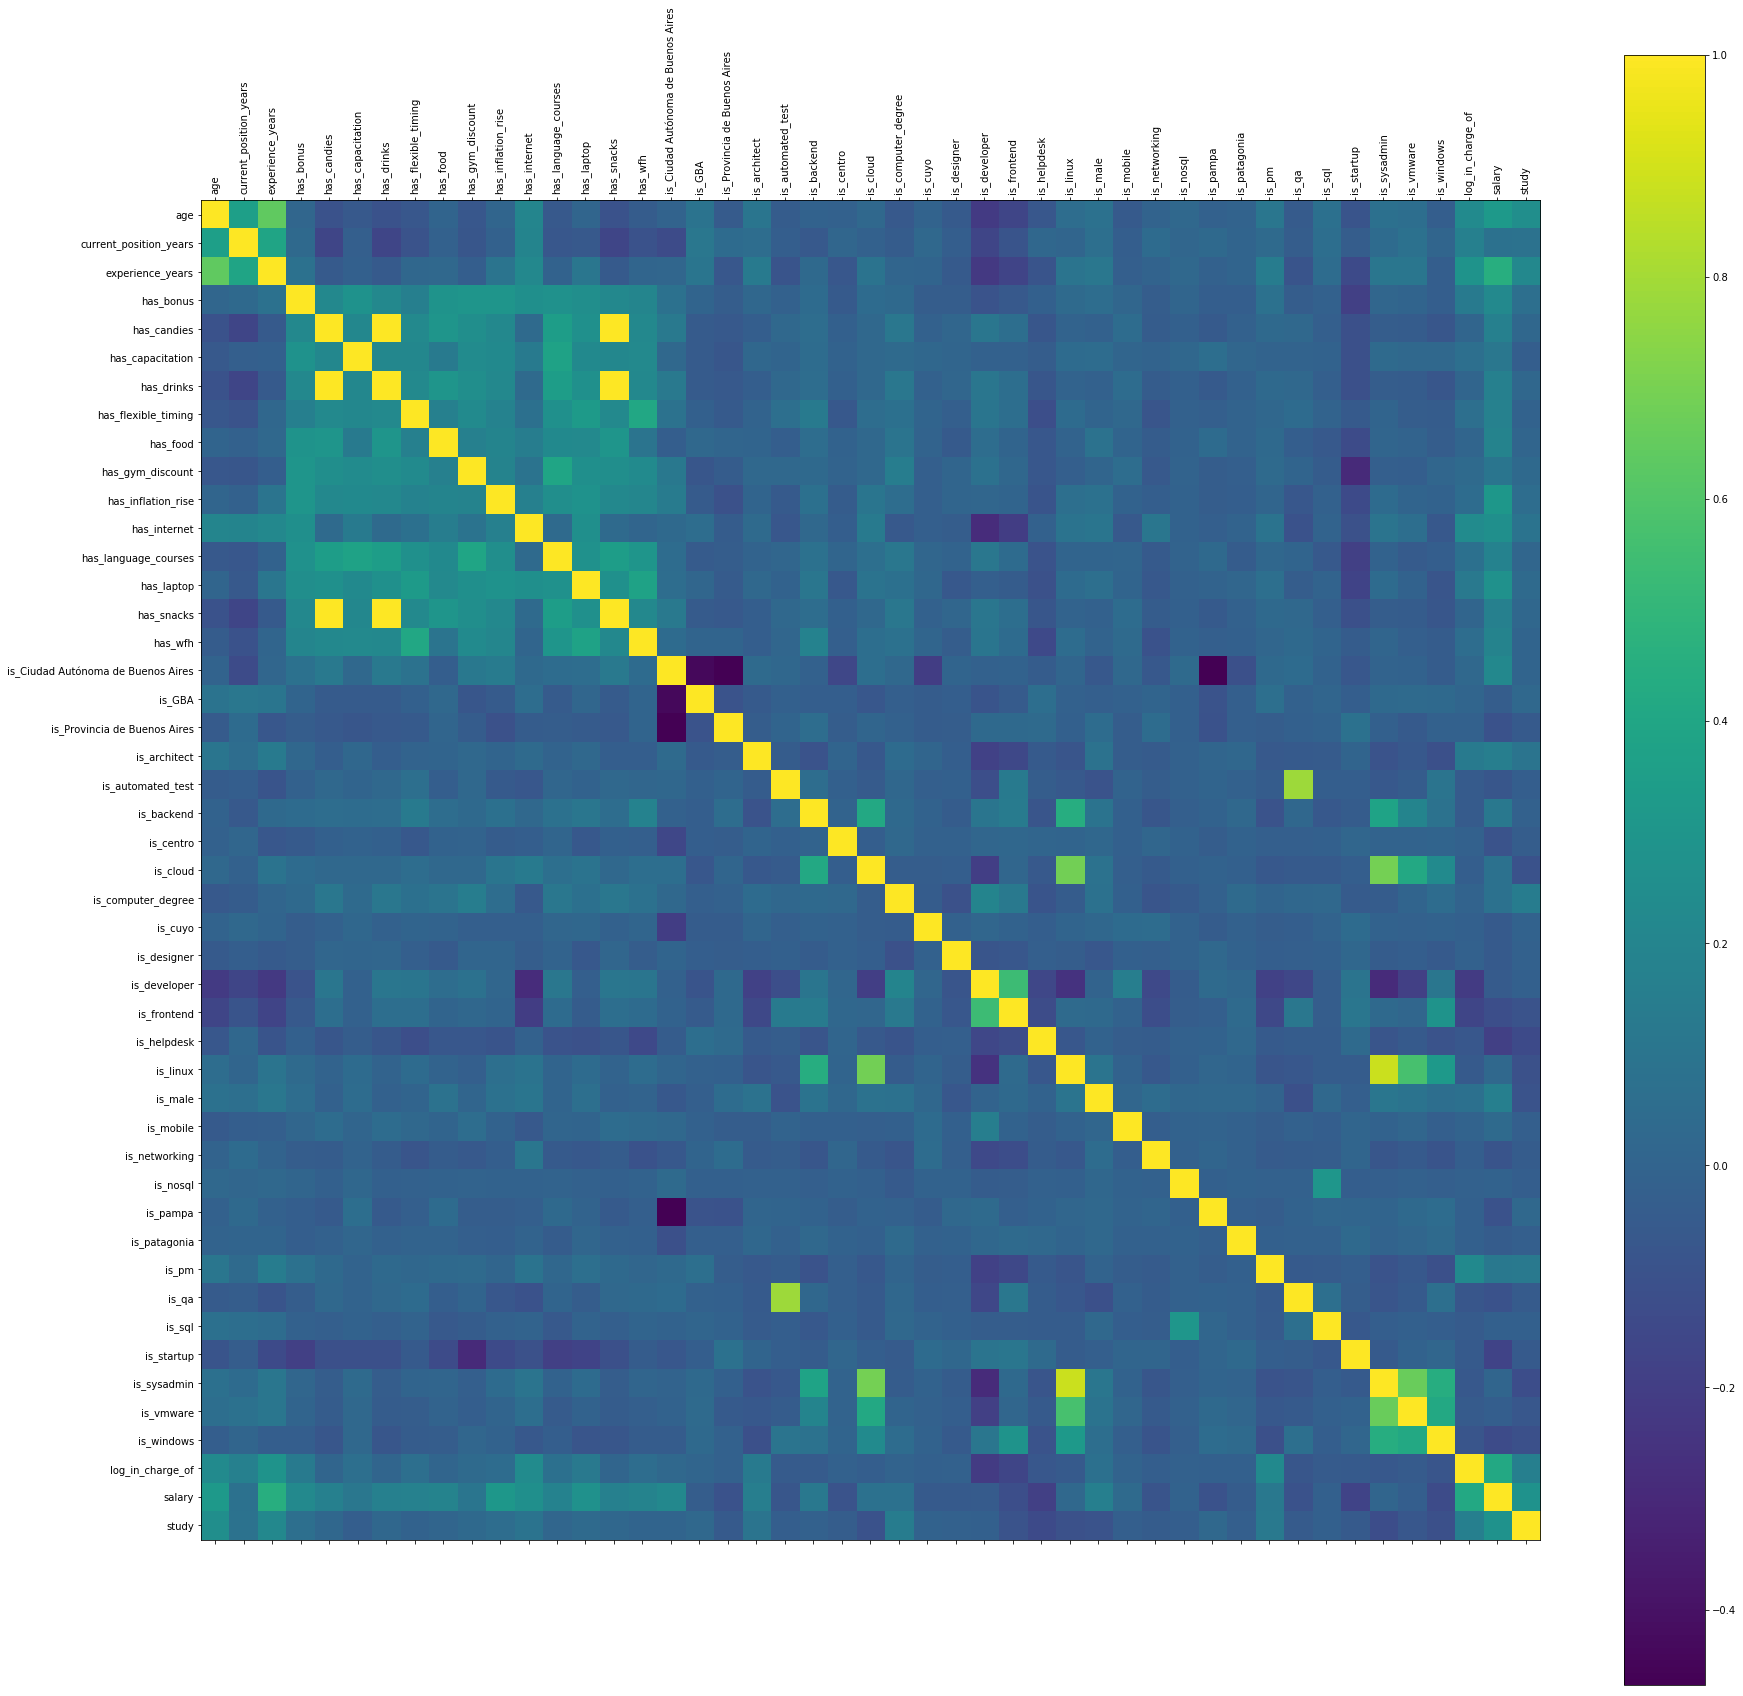

In [59]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
cax = ax.matshow(df_ready.corr());
fig.colorbar(cax)
ax.set_xticks(list(range(0, len(df_ready.columns))))
ax.set_yticks(list(range(0, len(df_ready.columns))))
ax.set_xticklabels(df_ready.columns, rotation='vertical')
ax.set_yticklabels(df_ready.columns);

In [115]:
stack = df_ready.corr().stack()
for col in df_ready.columns:
    for col2 in df_ready.columns:
        if col >= col2:
            stack[col][col2] = 0
        if stack[col][col2] < 0:
            stack[col][col2] *= -1
pd.DataFrame(stack.nlargest(40))

0
has_candies                        has_drinks                    1.000000
                                   has_snacks                    1.000000
has_drinks                         has_snacks                    1.000000
is_linux                           is_sysadmin                   0.884085
is_automated_test                  is_qa                         0.786843
is_cloud                           is_sysadmin                   0.693666
                                   is_linux                      0.688385
is_sysadmin                        is_vmware                     0.667296
age                                experience_years              0.640271
is_linux                           is_vmware                     0.573808
is_developer                       is_frontend                   0.539736
is_Ciudad Autónoma de Buenos Aires is_Provincia de Buenos Aires  0.468162
                                   is_pampa                      0.468162
experience_years                   salary                        0.449643
is_backend                         is_linux                      0.445340
is_sysadmin                        is_windows                    0.443825
is_Ciudad Autónoma de Buenos Aires is_GBA                        0.435247
is_vmware                          is_windows                    0.420291
log_in_charge_of                   salary                        0.419565
is_cloud                           is_vmware                     0.419262
is_backend                         is_cloud                      0.418071
has_flexible_timing                has_wfh                       0.412507
has_gym_discount                   has_language_courses          0.394796
current_position_years             experience_years              0.390531
is_backend                         is_sysadmin                   0.382361
has_laptop                         has_wfh                       0.380335
has_capacitation                   has_language_courses          0.380200
age                                current_position_years        0.359308
has_candies                        has_language_courses          0.346596
has_drinks                         has_language_courses          0.346596
has_language_courses               has_snacks                    0.346596
has_flexible_timing                has_laptop                    0.331144
is_linux                           is_windows                    0.328135
age                                salary                        0.325924
has_inflation_rise                 salary                        0.306679
is_nosql                           is_sql                        0.305216
has_candies                        has_food                      0.299827
has_drinks                         has_food                      0.299827
has_food                           has_snacks                    0.299827
has_bonus                          has_gym_discount              0.297471